# ECON 323 Final Project

Name: Kevin Nguyen, Anna Lin

**Note**: some of the code used here are extracted from my notes when I took CPSC 330 with Varada Kolhatkar. All rights and credits goes to her and the CPSC 330 teaching staff as a whole.

# Introduction

Software is used in almost every facet of life. Consumers use it to access data and perform calculations, while businesses use it to run their operations. It has become so accessible that most people don't realize just how much it impacts their daily life choices. The truth is, software is becoming increasingly important in the economy and software jobs have became more appealing as it is a promising job. As computer science students, we are interested in the factors that influence a software engineer's salary.

Our dataset is a complete dataset which contains employer name, location name, location country, location latitude, location longitude, job title, job title category, job title rank, total experience years, employer experience years, annual base pay, signing bonus, annual bonus, stock value bonus and comments from the employer.

List of important features we will be using in this project:
1. `location_name`
2. `location_country`
3. `job_title_category` (i.e. Software/Engineering/Other)
4. `job_title_rank` (seniority levels)
5. `total_experience_years` 
   (general expereience an indivual has in software field plus employer experience years)
6. `empolyer_experience_years`
7. `annual_base_pay`

In this project, we will firstly use `seaborn` and `matplotlib` for visualizing the relationship between base salary and some of these traits respectively. 
We then apply different ML models to analyze try to predict a software developer's salary based on the features above.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
# data downloaded from
df = pd.read_csv("./data/salaries_clean.csv", encoding="latin-1")
print(len(df))
df.head()

1655


,salary_id,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay,signing_bonus,annual_bonus,stock_value_bonus,comments,submitted_at
0,1,opower,"san francisco, ca",CA,US,37.77,-122.41,systems engineer,Engineering,NaN,13.0,2.0,125000.0,5000.0,0.0,5000 shares,Don't work here.,3/21/16 12:58
1,3,walmart,"bentonville, ar",AR,US,36.36,-94.20,senior developer,Software,Senior,15.0,8.0,65000.0,NaN,5000.0,"3,000",NaN,3/21/16 12:58
2,4,vertical knowledge,"cleveland, oh",OH,US,41.47,-81.67,software engineer,Software,NaN,4.0,1.0,86000.0,5000.0,6000.0,0,NaN,3/21/16 12:59
3,6,netapp,waltham,NaN,NaN,NaN,NaN,mts,Other,NaN,4.0,0.0,105000.0,5000.0,8500.0,0,NaN,3/21/16 13:00
4,12,apple,cupertino,NaN,NaN,NaN,NaN,software engineer,Software,NaN,4.0,3.0,110000.0,5000.0,7000.0,150000,NaN,3/21/16 13:02


### Splitting the data into training and testing sets

In [3]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)
train_df = train_df.dropna(subset = ["annual_base_pay"])
test_df = test_df.dropna(subset = ["annual_base_pay"])

X_train = train_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at"]) # drop the uncnessary columns as well
y_train = train_df["annual_base_pay"]

X_test = test_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at"]) # drop the uncnessary columns as well
y_test = test_df["annual_base_pay"]

## since there are not that many NaN in "annual_base_pay" - we'll just drop them

display(X_train.head(10))
display(y_train.head())
print(X_train.shape[0], y_train.shape[0])

,employer_name,location_name,location_country,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay
483,expedia,seattle,NaN,Software,2,3.0,3.0,105000.0
132,vmware,palo alto,NaN,Other,NaN,4.0,3.0,125000.0
1002,microsoft,redmond,NaN,Other,Senior,30.0,3.0,180000.0
72,conde nast,"new york city, ny",US,Software,2,8.0,4.0,112000.0
1215,microsoft,"redmond, wa",US,Software,NaN,1.5,1.5,110000.0
987,higher learning technology,iowa,US,Software,NaN,15.0,2.0,130000.0
1395,health ensurance company,germany,DE,Engineering,NaN,10.0,10.0,67200.0
903,disney interactive,"glendale, ca",US,Software,NaN,4.0,3.0,88000.0
440,state farm,"phoenix, az",US,Software,NaN,2.0,1.0,63000.0
116,facebook,menlo park,NaN,Software,NaN,3.0,1.0,150000.0


483     105000.0
132     125000.0
1002    180000.0
72      112000.0
1215    110000.0
Name: annual_base_pay, dtype: float64

1322 1322


# Visualization

Note: due to some computation limitation, we are only able to visualize a subset of a data. We found that a sample size of `n = 300` works best (any bigger and it crashes our kernel).

In [4]:
n = 300 # declare sample size

### Visualization of annual base pay versus seniority 

Visualization allows our userd to recognize relationships and patterns between the data, and makes the meaning of the relationship more obvious to observe.

We are going to examine the relationship between `annual_base_salary` and `job_title_rank` and see what's the impact of seniority on base salary. 

Before we do that, we're going to alter `job_title_rank` columns just a little bit to provide a better meaning. Currently it has the following values: `["Senior", "Intern", "Junior", "2", "1", "3","4", "NaN"]` which does not tell us a whole much. We will change 1, 2, 3, 4 to `["SDE 1/2/3/4"]`, respectively. 

Furthermore, from looking at the data from columns `job_title` and `job_title_rank`, it seems that most `"NaN"` in the `job_title_rank` should be associated with `Junior` rank by looking at the associated values in `job_title`. Combined with this [article](https://newsletter.pragmaticengineer.com/p/growing-a-junior-team) by Gergely Orosz, there's often more Junior Engineers at a company than Senior Engineers. For these reasons, we'll also impute the `"NaN"` in the `job_title_rank` column to be `"Junior"`

In [5]:
viz_data = train_df.copy()

# before transformation
print(viz_data["job_title_rank"].value_counts(dropna=False))

def transform_rank(x):
    if x in {"1", "2", "3", "4"}:
        # print(x)
        return "SDE {}".format(x) 
    elif pd.isnull(x):
        return "Junior"
    else:
        return str(x)

viz_data["job_title_rank"] = viz_data["job_title_rank"].map(transform_rank)

# after transformation
print()
print(viz_data["job_title_rank"].value_counts())

NaN       990
Senior    200
2          53
1          31
3          16
Intern     14
Junior     13
4           5
Name: job_title_rank, dtype: int64

Junior    1003
Senior     200
SDE 2       53
SDE 1       31
SDE 3       16
Intern      14
SDE 4        5
Name: job_title_rank, dtype: int64


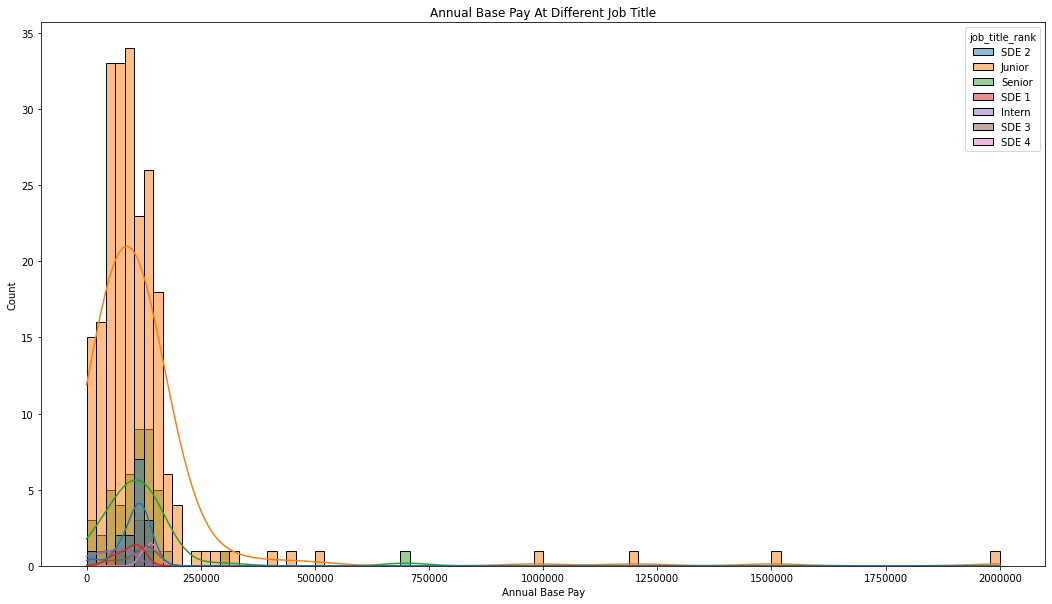

In [6]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(x='annual_base_pay', data=viz_data.head(n), ax=ax, kde=True, hue='job_title_rank')

ax.set_xlabel("Annual Base Pay")
ax.set_title("Annual Base Pay At Different Job Title")

plt.gca().ticklabel_format(axis='x', style='plain')
plt.show()

We assume the higher the `job_title_rank` (seniority), the higher the `annual_base_salary`. The graph shows us the result we expected; however, we noticed some exceptions for `Junior`, we acknowledge that their might be some outliers in the data due to the way we've decided to impute our data. However, on average, our assumption was correct, the higher your rank is, the higher your annual base pay is.

### Visualization of annual base pay versus different job title

Now, we examine the relationship between `annual_base_salary` and `job_title_category` and see which type of software job has the highest `annual_base_salary`.

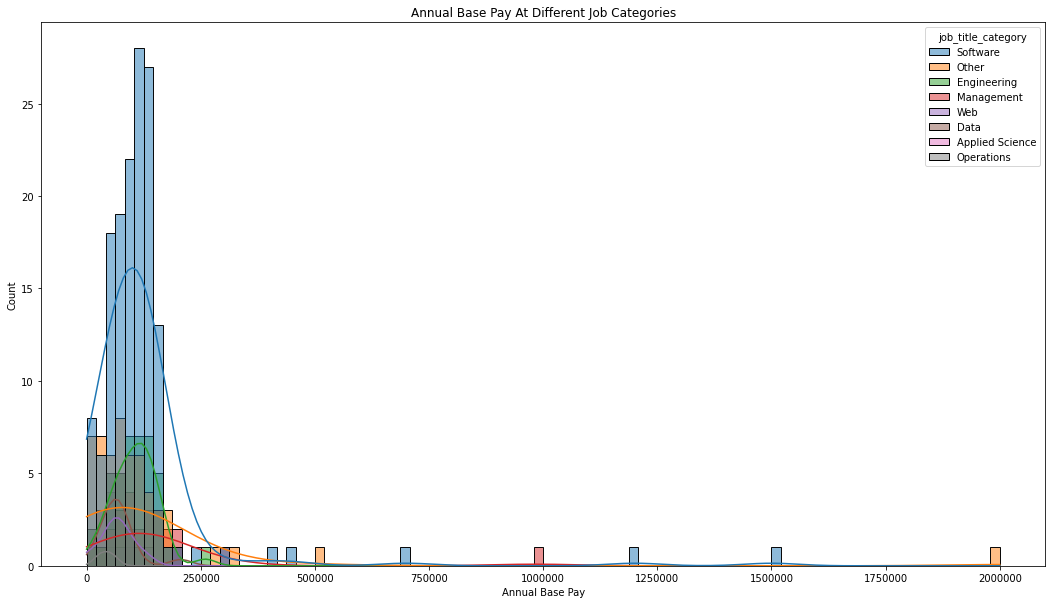

In [7]:
fig, ax = plt.subplots(figsize=(18,10))
viz_data = train_df.copy()

sns.histplot(x='annual_base_pay', data=viz_data.head(n), ax=ax, kde=True, hue='job_title_category')

ax.set_xlabel("Annual Base Pay")
ax.set_title("Annual Base Pay At Different Job Categories")

plt.gca().ticklabel_format(axis='x', style='plain')
plt.show()

`Management` has the highest `annual_base_salary` as shown in the group. Despite of that, technical jobs like `Software` and `Engineering`, on average, usually have a higher `annual_base_salary` in general. Once again, we find and acknowledge that `Management` might be underrepresented and `Software` might be overrepresented in our dataset. 

### Visualization of annual base pay versus different country

We are also interested in how `annual_base_salary` differs in different countries. We are going to visulize and count `annual_base_salary` in every `location_country`.

Again, there are some missing data so we'll also be imputing `"NaN"` from the `"location_country"` with the most common occurence - which is the US

In [8]:
viz_data = train_df.copy()
countries = viz_data["location_country"].value_counts(dropna=False)
print("Before transformation")
print(countries[:3])

def transform_country(x):
    if pd.isnull(x):
        return "US"
    else:
        return x 
    
viz_data["location_country"] = viz_data["location_country"].map(transform_country)
countries = viz_data["location_country"].value_counts(dropna=False)
print("\nAfter transformation")
print(countries[:3])

Before transformation
NaN    693
US     436
CA      33
Name: location_country, dtype: int64

After transformation
US    1129
CA      33
DE      19
Name: location_country, dtype: int64


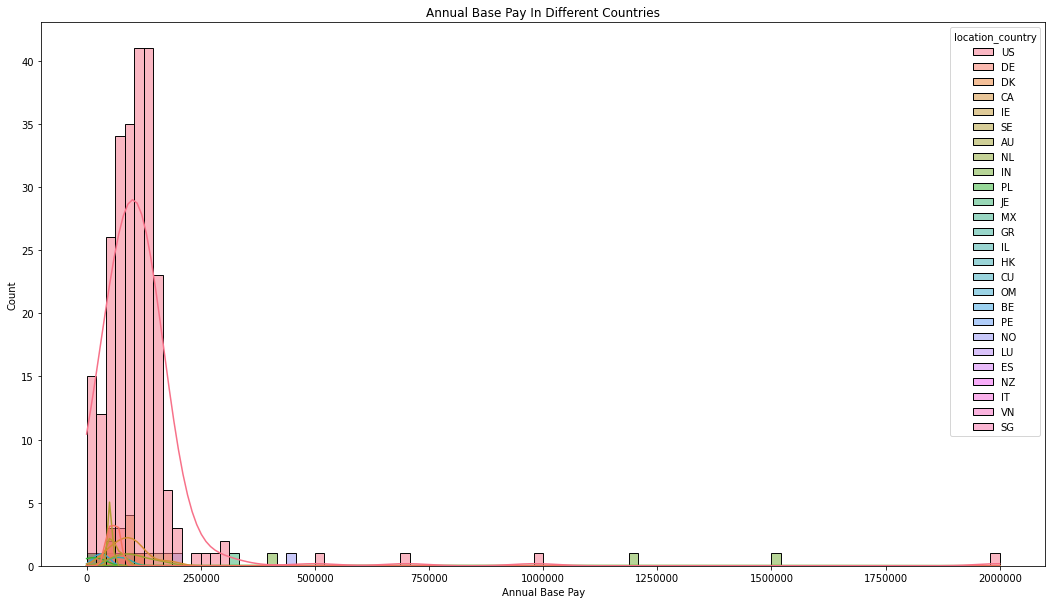

In [9]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(x='annual_base_pay', data=viz_data.head(n), ax=ax, kde=True, hue='location_country')

ax.set_xlabel("Annual Base Pay")
ax.set_title("Annual Base Pay In Different Countries")

plt.gca().ticklabel_format(axis='x', style='plain')
plt.show()

Although `US` data might be overrepresented in our dataset, it is clear that `US` has the highest `annual_base_pay` overall. 

### Visualization of annual base pay versus total years of experience

We also believe experience in software prior to their current position is also important. 

For visualization's sake, we believe that for `years_of_experience` - it would make sense to group them into buckets as opposed to leaving it as a continuous variable.

And since we group them into buckets, it makes more sense to visualize our graoh with a Bar Chart.

In [10]:
viz_data = train_df.copy()
yoe = viz_data["total_experience_years"].value_counts(dropna=False)
print("Before transformation")
print(yoe[:5])

def yoe_transformation(x):
    if x < 1:
        return "< 1"
    elif 1 <= x < 3:
        return "1 - 3"
    elif 3 <= x < 5:
        return "3 - 5"
    elif 5 <= x <= 10:
        return "5 - 10"
    else:
        return "10 +"
        
viz_data["total_experience_years"] = viz_data["total_experience_years"].transform(yoe_transformation)
yoe = viz_data["total_experience_years"].value_counts(dropna=False)
print("\nAfter transformation")
print(yoe)

Before transformation
3.0    131
5.0    131
Name: total_experience_years, dtype: int64

After transformation
5 - 10    516
10 +      264
3 - 5     251
1 - 3     240
< 1        51
Name: total_experience_years, dtype: int64


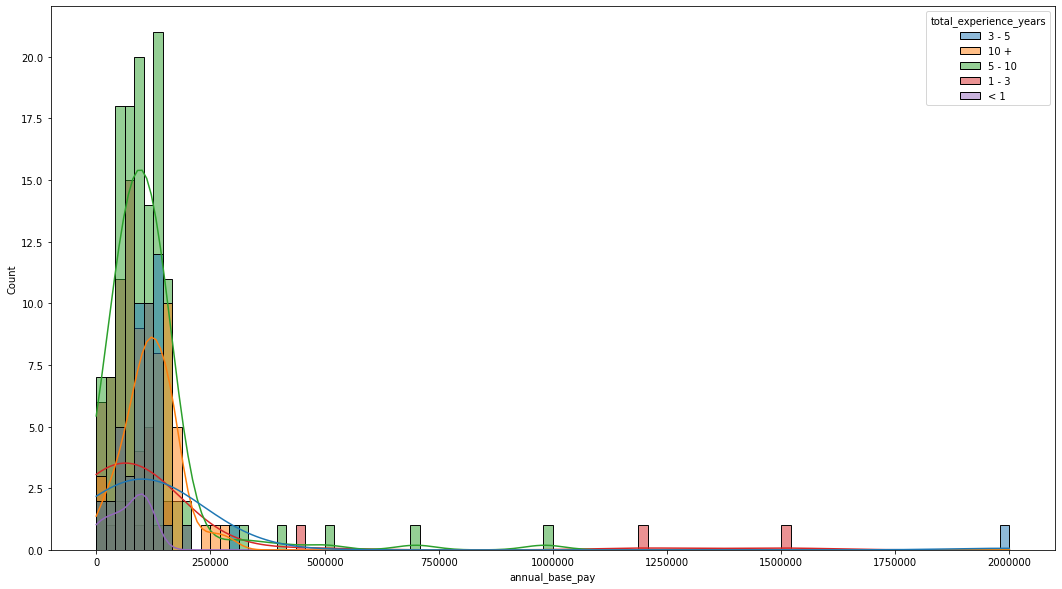

In [11]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(x='annual_base_pay', data=viz_data.head(n), ax=ax, kde=True, hue='total_experience_years')
plt.gca().ticklabel_format(axis='x', style='plain')
plt.show()

We expected for their to be a direct relationship between years of experience and how much you earn. So we expected the people with 10+ years of experience to be the highest earner. Average wise, this does seem to be the case. However, there are some interesting observation, such as people with 3-5 years of experience seems to be doing better than people with 5-10 year of experience, on average. Another interesting observation is how well paid people with less than 1 year of experience is. However, there is a significant under-representation of that group in our dataset. Another factor that could have attributed to this response bias, amongst CS students, the salary of your internship is a big point of comparison, and thus, students are more likely to report their earnings to Glasshouse if it is higher than their peers, which might skew the data significantly upwards.

# Pre-processing

First, declaring my own imputer

In [12]:
class CustomImputer(TransformerMixin):
    def fit(self, X, y):
        self.companies_set = set(X["employer_name"].value_counts().sort_values(ascending = False)[:20])
        self.location_set = set(X["location_name"].value_counts().sort_values(ascending = False)[20:])
        return self 

    def transform(self, X):
        X_copy = X.copy()
        X_copy["job_title_rank"] = X_copy["job_title_rank"].map(self.transform_rank)
        X_copy["location_country"] = X_copy["location_country"].map(self.transform_country)
        X_copy["employer_name"] = X_copy["employer_name"].map(self.transform_employer)
        X_copy["location_name"] = X_copy["location_name"].map(self.transform_location)
        # X["total_experience_years"] = X["total_experience_years"].transform(self.transform_yoe)
        return X_copy


    def transform_rank(self, x):
        if x in {"1", "2", "3", "4"}:
            # print(x)
            return "SDE {}".format(x) 
        elif pd.isnull(x):
            return "Junior"
        else:
            return str(x)

    def transform_country(self, x):
        if pd.isnull(x):
            return "US"
        else:
            return x 
        
    def transform_yoe(self, x):
        if x < 1:
            return "< 1"
        elif 1 <= x < 3:
            return "1 - 3"
        elif 3 <= x < 5:
            return "3 - 5"
        elif 5 <= x <= 10:
            return "5 - 10"
        else:
            return "10 +"
    
    def transform_employer(self, x):
        if x in self.companies_set:
            return x 
        else:
            return "Other"

    def transform_location(self, x):
            if x in self.location_set:
                return x 
            else:
                return "Other"

Defining a Column Transformer to apply the correct pre-processing depending on the type of the columns. We'll be applying One Hot Encoding to the categorical features and scaling and imputation to numerical features. Finally, we're applying Ordinal Encoding to the ordinal features.

In [13]:
categorical_features = ["employer_name", "location_name", "location_country", "job_title_category"]
numerical_features = ["employer_experience_years", "total_experience_years"]
ordinal_features = ["job_title_rank"]

title_rank_levels = ["Intern", "SDE 1", "SDE 2", "Junior", "SDE 3", "Senior", "SDE 4"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
ordinal_transformer = OrdinalEncoder(categories=[title_rank_levels])
numerical_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())


ct = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
    (ordinal_transformer, ordinal_features),
)


Example of declaring a pipeline that utilizes both our custom imputer and the column transformer

In [14]:

pipeline = make_pipeline(
    CustomImputer(),
    ct
)

transformed_X = pipeline.fit_transform(X_train, y_train)
column_names = numerical_features + list(
    ct.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )) + list(
        ct.named_transformers_["ordinalencoder"].get_feature_names_out(
        ordinal_features
    )
)

# pd.DataFrame(temp, columns = column_names)

transformed_X_train = pd.DataFrame(transformed_X.toarray(), columns = column_names)
transformed_X_train.head()



,employer_experience_years,total_experience_years,employer_name_Other,location_name_Other,location_country_AR,location_country_AU,location_country_BE,location_country_BG,location_country_BM,location_country_BR,...,location_country_ZA,job_title_category_Applied Science,job_title_category_Data,job_title_category_Engineering,job_title_category_Management,job_title_category_Operations,job_title_category_Other,job_title_category_Software,job_title_category_Web,job_title_rank
0,0.086653,-0.662216,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,0.086653,-0.485939,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
2,0.086653,4.097259,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
3,0.383051,0.219169,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,-0.357944,-0.926631,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


# Modelling

### Logistic Regression

The first model we'll be trying out is logistic regression from `sklearn`. We'll first perform hyperparemeter tuning and cross validation on the model to pick the best `C` value

In [15]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-5, 5, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}

for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(
        CustomImputer(),
        ct,
        Ridge(alpha=alpha)
    )
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.00001,0.020500,-18444.193340
1,0.00010,0.020499,-18349.365651
2,0.00100,0.020500,-18443.366067
3,0.01000,0.020500,-18435.739136
4,0.10000,0.020490,-18288.493332
5,1.00000,0.020271,-17961.128570
6,10.00000,0.019210,-16899.878617
7,100.00000,0.018042,-13458.361233
8,1000.00000,0.012751,-5574.611533
9,10000.00000,0.003327,-1392.230116


We will now run the funal model on testing set using the hyperparameter $\alpha = 0.001$ (because it yielded the "best" results)

In [16]:
a = results_df.loc[results_df["mean_cv_scores"].idxmax()]["alpha"]
print("alpha =", a)

final_ridge_pipe = make_pipeline(
    CustomImputer(),
    ct,
    Ridge(alpha=a)
)

final_ridge_pipe.fit(X_train, y_train)
preds = final_ridge_pipe.predict(X_test)
# # print(preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)

alpha = 10000.0
RMSE: 137905776650836.62
R^2 =  -0.8628705942691091


As you can see, the results here are very poor. Since we are trying to get RMSE as close to 0 as possible and $R^2$ as close to 1 as possible. Both these scores imply that the function is worse drawing a straight line to predict our results

### LightGBM

Next, we'll be trying the `LGBMRegressor` model. Again, we'll be doing hyperparmeter tuning. But since `LGBM` has multiple hyperparmeterse, we'll employ the help of sk-learn's `RandomSearchCV`

In [17]:
lgbm_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LGBMRegressor()
)

param_grid = {
    "lgbmregressor__num_leaves": [5, 10, 31, 100, 1000, 10000],
    "lgbmregressor__max_depth": [-1, 0, 5, 10, 20, 30, 40]
}

random_search = RandomizedSearchCV(
    lgbm_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train);

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmregressor__num_leaves",
        "param_lgbmregressor__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T



rank_test_score,1,1,3,4,5,6,6,6,9,9,9,9,9,9,9,9,17,17,19,19
mean_test_score,-174897.243671,-174897.243671,-175970.365767,-175973.526455,-175973.541194,-175973.608083,-175973.608083,-175973.608083,-175973.866908,-175973.866908,-175973.866908,-175973.866908,-175973.866908,-175973.866908,-175973.866908,-175973.866908,-175973.94968,-175973.94968,-176148.281213,-176148.281213
param_lgbmregressor__num_leaves,5,5,10,31,31,1000,10000,100,100,1000,1000,10000,10000,10000,100,100,10,10,10000,100
param_lgbmregressor__max_depth,-1,5,5,10,20,10,10,10,40,-1,0,30,-1,40,0,-1,0,20,5,5
mean_fit_time,0.018646,0.020165,0.019467,0.036113,0.036709,0.059417,0.068217,0.030104,0.041454,0.077203,0.063566,0.387278,0.306212,0.382174,0.04618,0.045158,0.024472,0.021942,0.02535,0.029372


In [18]:
num_leaves = random_search.best_params_["lgbmregressor__num_leaves"]
max_depth = random_search.best_params_["lgbmregressor__max_depth"]

lgbm_pipe_final = make_pipeline(
    CustomImputer(),
    ct,
    LGBMRegressor(num_leaves=num_leaves, max_depth = max_depth, random_state=2022)
)

lgbm_pipe_final.fit(X_train, y_train)
preds = lgbm_pipe_final.predict(X_test)

rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)

RMSE: 5860163561452311.0
R^2 =  -78.16076208958877


Here you can see that it does not seem that our model is improving, it's actually doing worst

### CatBoost

Next we'll be trying `CatBoostRegressor` which is another gradient boosting model

In [19]:
catboost_pipe = make_pipeline(
    CustomImputer(),
    ct,
    CatBoostRegressor()
)

param_grid = {
    'catboostregressor__max_depth': [3, 4, 5, 10, 15],
    'catboostregressor__n_estimators': [50, 100, 200, 300, 400]
}

random_search = RandomizedSearchCV(
    catboost_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train);

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_catboostregressor__max_depth",
        "param_catboostregressor__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

Learning rate set to 0.086998
Learning rate set to 0.086998
Learning rate set to 0.086998
Learning rate set to 0.087011
Learning rate set to 0.086998
Learning rate set to 0.087011
Learning rate set to 0.087011
Learning rate set to 0.087011
0:	learn: 300731321.3151591	total: 56ms	remaining: 22.4s
1:	learn: 294175302.5809604	total: 56.2ms	remaining: 11.2s
2:	learn: 287764180.3306381	total: 56.4ms	remaining: 7.47s
3:	learn: 283646931.1519484	total: 56.7ms	remaining: 5.61s
4:	learn: 277468684.7912399	total: 56.8ms	remaining: 4.49s
5:	learn: 271426436.4504828	total: 57.1ms	remaining: 3.75s
6:	learn: 266887821.9908358	total: 57.3ms	remaining: 3.22s
7:	learn: 261078016.8150959	total: 57.5ms	remaining: 2.81s
8:	learn: 255397479.4525486	total: 57.6ms	remaining: 2.5s
9:	learn: 249838636.3327540	total: 57.8ms	remaining: 2.25s
0:	learn: 1536741.6332258	total: 55.2ms	remaining: 22s
10:	learn: 244401983.4167766	total: 57.9ms	remaining: 2.05s
11:	learn: 239084763.2317965	total: 58.1ms	remaining: 1.88

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,-1377.909584,-2480.569744,-3940.80579,-4090.552872,-4740.874068,-4887.953817,-4943.836755,-6143.322149,-6420.620043,-6421.99855,-6656.767263,-6982.413911,-7742.374919,-7743.253451,-9941.171187,-10601.73665,-12267.302342,-16491.196406,-21436.332843,-26093.319992
param_catboostregressor__max_depth,10,10,15,5,10,15,4,4,4,4,5,5,4,5,3,15,3,3,3,3
param_catboostregressor__n_estimators,50,400,400,100,300,100,50,200,100,300,200,400,400,50,50,50,200,100,400,300
mean_fit_time,0.212628,1.206682,16.766146,0.099819,1.320174,3.635575,0.062481,0.112576,0.0818,0.126047,0.174492,0.314632,0.274809,0.056192,0.107187,2.216241,0.113493,0.076424,0.169232,0.201114


In [20]:
n_estimators = random_search.best_params_["catboostregressor__n_estimators"]
max_depth = random_search.best_params_["catboostregressor__max_depth"]

catboost_pipe_final = make_pipeline(
    CustomImputer(),
    ct,
    CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth)
)

catboost_pipe_final.fit(X_train, y_train)
preds = catboost_pipe_final.predict(X_test)

rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)


Learning rate set to 0.488733
0:	learn: 249484241.6933185	total: 1.25ms	remaining: 61.5ms
1:	learn: 218985466.0833383	total: 2.55ms	remaining: 61.3ms
2:	learn: 192224680.0920338	total: 3.47ms	remaining: 54.4ms
3:	learn: 168737511.4531744	total: 4.26ms	remaining: 49ms
4:	learn: 148179269.6430387	total: 5.25ms	remaining: 47.2ms
5:	learn: 130076972.6839285	total: 6.25ms	remaining: 45.8ms
6:	learn: 114269843.4330260	total: 7.29ms	remaining: 44.8ms
7:	learn: 100424210.5654962	total: 8.31ms	remaining: 43.7ms
8:	learn: 88310856.6055199	total: 8.94ms	remaining: 40.7ms
9:	learn: 77695019.4039255	total: 9.19ms	remaining: 36.8ms
10:	learn: 68205385.2060832	total: 10.4ms	remaining: 36.9ms
11:	learn: 59878875.3749632	total: 11.3ms	remaining: 35.9ms
12:	learn: 52567072.1712535	total: 12.5ms	remaining: 35.6ms
13:	learn: 46157075.2366889	total: 13.6ms	remaining: 35ms
14:	learn: 40523129.2701757	total: 15.4ms	remaining: 35.9ms
15:	learn: 35578065.4133282	total: 16.6ms	remaining: 35.3ms
16:	learn: 31238

We can see from here that the $R^2$ score is the best we've seen so far, but the RMSE score is actually one of the worst. 

# Conclusion and Further Research

As you can see, the results achieved by all these different models were below par at best. We believe this may be due to the fact that the data might have been unfit for a regression model. We also believe that the data might have been to noisy - there were orignially a lot of N/A values that we had to impute. For the future, we believe we can improve model performance by obtaining more data, this dataset only had 1655 rows which would have been fine if the data was a lot cleaner. Another thing we could do is perform feature engineering on certain columns to extract more beneifical data from them. 

However, experiementing further, we wanted to see how well different ML models would perform if we tweak the research question to be "Predict whether employee will make more than \$100k annual base salary" (basically, turning it into a classification problem). We'll be using accuracy as our metric of choice for this problem as this dataset is actually quite balanced in terms of 1s (over 100k) and 0s (less than 100k)

In [21]:
df = pd.read_csv("./data/salaries_clean.csv", encoding="latin-1")
df.dropna(subset = ["annual_base_pay"])
df["more_than_100k"] = df["annual_base_pay"].transform(lambda x: x > 100000)
display(df.head())

df["more_than_100k"].value_counts()

,salary_id,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay,signing_bonus,annual_bonus,stock_value_bonus,comments,submitted_at,more_than_100k
0,1,opower,"san francisco, ca",CA,US,37.77,-122.41,systems engineer,Engineering,NaN,13.0,2.0,125000.0,5000.0,0.0,5000 shares,Don't work here.,3/21/16 12:58,True
1,3,walmart,"bentonville, ar",AR,US,36.36,-94.20,senior developer,Software,Senior,15.0,8.0,65000.0,NaN,5000.0,"3,000",NaN,3/21/16 12:58,False
2,4,vertical knowledge,"cleveland, oh",OH,US,41.47,-81.67,software engineer,Software,NaN,4.0,1.0,86000.0,5000.0,6000.0,0,NaN,3/21/16 12:59,False
3,6,netapp,waltham,NaN,NaN,NaN,NaN,mts,Other,NaN,4.0,0.0,105000.0,5000.0,8500.0,0,NaN,3/21/16 13:00,True
4,12,apple,cupertino,NaN,NaN,NaN,NaN,software engineer,Software,NaN,4.0,3.0,110000.0,5000.0,7000.0,150000,NaN,3/21/16 13:02,True


False    872
True     783
Name: more_than_100k, dtype: int64

In [22]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)

X_train = train_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at", "annual_base_pay"]) # drop the uncnessary columns as well
y_train = train_df["more_than_100k"]

X_test = test_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at", "annual_base_pay"]) # drop the uncnessary columns as well
y_test = test_df["more_than_100k"]

### Logistic Regression

The first model we'll be trying out is a very basic model, Logistic Regression. We'll also be performing hyperparameter tuning

In [23]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_ridge = make_pipeline(
        CustomImputer(),
        ct,
        LogisticRegression(C=C)
    )
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.519826,0.519637
1,0.0010,0.611405,0.598931
2,0.0100,0.645961,0.631432
3,0.1000,0.670884,0.663139
4,1.0000,0.670127,0.660109
5,10.0000,0.673527,0.660109
6,100.0000,0.672393,0.655577
7,1000.0000,0.673149,0.658596
8,10000.0000,0.672015,0.656332
9,100000.0000,0.674848,0.655577


In [24]:
C = results_df.loc[results_df["mean_cv_scores"].idxmax()]["C"]
print("C =", C)

final_lr_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LogisticRegression(C=C)
)

final_lr_pipe.fit(X_train, y_train)
preds = final_lr_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

C = 0.1
Accuracy: 0.6978851963746223


As you can see, we are able to accurately predict 69% of the test data. I would say this is a drastic improvement from our regression models

### LGBMClassifier

Next, we'll be trying another LGBM model, but this time it's `LGBMClassifier` as opposed to `LGBMRegression`

In [25]:
pipe_lgbm = make_pipeline(
    CustomImputer(),
    ct,
    LGBMClassifier()
)

param_grid = {
    "lgbmclassifier__num_leaves": [5, 10, 31, 100, 1000, 10000],
    "lgbmclassifier__max_depth": [-1, 0, 5, 10, 20, 30, 40]
}

random_search = RandomizedSearchCV(
    pipe_lgbm, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train);

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,3,3,5,5,7,8,9,9,9,12,12,12,12,12,12,12,12,20
mean_test_score,0.671458,0.671458,0.665417,0.665417,0.661644,0.661644,0.656364,0.652559,0.645014,0.645014,0.645014,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.636707
param_lgbmclassifier__num_leaves,100,10000,10,10,5,5,10,31,100,1000,10000,100,10000,1000,100,1000,100,10000,10000,31
param_lgbmclassifier__max_depth,5,5,20,0,5,-1,5,10,10,10,10,-1,40,0,0,-1,40,-1,30,20
mean_fit_time,0.032911,0.050284,0.027142,0.026319,0.020972,0.027087,0.033641,0.041789,0.042365,0.068418,0.055181,0.056768,0.395474,0.07673,0.049466,0.102216,0.065566,0.413772,0.388569,0.03922


In [26]:
num_leaves = random_search.best_params_["lgbmclassifier__num_leaves"]
max_depth = random_search.best_params_["lgbmclassifier__max_depth"]

final_lgbm_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth)
)

final_lgbm_pipe.fit(X_train, y_train)
preds = final_lgbm_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

Accuracy: 0.6978851963746223


Interestingly, despite being a much more complex and involved model, LGBM does not yield a better accuracy score. Instead, it actually yielded the same accuracy as Logistic Regression

### Random Forest

Next, we'll be using the `RandomForestClassifier` model which is a ensemble, tree-based model.

In [27]:
pipe_rf = make_pipeline(
    CustomImputer(),
    ct,
    RandomForestClassifier()
)

param_grid = {
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50],
    "randomforestclassifier__n_estimators": [200, 400, 600, 800, 1000]
}

random_search = RandomizedSearchCV(
    pipe_rf, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train)

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.669943,0.668419,0.666907,0.665403,0.664651,0.643499,0.642736,0.642724,0.641221,0.63972,0.639714,0.638951,0.63821,0.637453,0.637444,0.635946,0.635938,0.635192,0.634431,0.63066
param_randomforestclassifier__max_depth,10,10,10,10,10,20,20,50,20,40,30,20,30,50,40,40,30,20,30,50
param_randomforestclassifier__n_estimators,200,600,800,400,1000,800,1000,200,400,800,600,600,1000,400,200,1000,200,200,400,1000
mean_fit_time,0.27317,1.274148,0.967985,0.488382,1.334116,1.628093,1.930759,0.456539,0.893687,1.352222,1.394929,1.559164,2.222679,0.935905,0.399951,2.269893,0.505999,0.462537,0.835996,2.415431


In [28]:
max_depth = random_search.best_params_["randomforestclassifier__max_depth"]
n_estimators = random_search.best_params_["randomforestclassifier__n_estimators"]

final_rf_pipe = make_pipeline(
    CustomImputer(),
    ct,
    RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
)

final_rf_pipe.fit(X_train, y_train)
preds = final_rf_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

Accuracy: 0.716012084592145


Here, we're able to see a score of 71% which is an improvement on all of the previous classification models

# Final Remarks

We see that once we tweaked the research question to a classification problem, we were able to yield much more promising results. Some challenges we face during the process are: overrepresented and underrepresented data. We believe that with a lot more data, as well as additional data cleaning, we'd be able to see great improvements in both the regression models and especially the classification models. This is an important and potentially useful thing to know for new grads who are just entering the workforce, looking for jobs in the software field. We also learned a lot about the factors that affect a software developer's salary. In addition to that, we once again recognize the power of machine learning and how it can be applied to solve every-day problems.

